In [1]:
import sys
sys.path.append('../')
from _imports import *

import shap

In [45]:
train_X = pd.read_csv('../data/impute/train_X.csv').to_numpy()
train_y = pd.read_csv('../data/preprocess/train_y.csv').iloc[:, 0].to_numpy()

types: pd.Series = pd.read_csv('../data/fix/meta/types.csv', index_col=0).iloc[:, 0]

raw_features = pd.read_csv('../data/fix/train_X.csv').columns.tolist()
features = pd.read_csv('../data/impute/train_X.csv').columns.tolist()

In [3]:
model = keras.saving.load_model("../data/predict/model/model.keras")

def predict(X):
  return model.predict(X, verbose=0)[:, 0]

In [4]:
m = train_X.shape[0]
n_features = train_X.shape[1]
n_num = int(np.sum((types == 'numerical'))) + int(np.sum((types == 'ordinal')))

In [13]:
yp0 = predict(train_X)
e0 = ((yp0 - train_y) ** 2).mean()
e0

0.003584606455843767

In [36]:
rng = np.random.RandomState(1)
errs = np.zeros(n_features)
errse = np.zeros(n_features)
for i in range(n_features):
  X1 = train_X.copy()
  
  K = 10
  e1s = np.zeros(K)
  for j in range(K):
    if i < n_num:
      X1[:, i] = rng.normal(0, 1, m)
    else:
      X1[:, i] = rng.randint(0, 2, m)
    yp1 = predict(X1)
    e1 = ((yp1 - train_y) ** 2).mean()    
    e1s[j] = e1
  
  e1m = e1s.mean()
  e1e = e1s.std()
  
  err = (e1m - e0) / e0
  erre = e1e / e0
  errs[i] = err
  errse[i] = erre
  
  print(i, e1m, e1e)

0 0.0068010773321258156 0.000180951907229783
1 0.01803910572039552 0.0006346042955242276
2 0.03698283363330249 0.0012046398747046975
3 0.008910871177914777 0.00030792717589398454
4 0.0067463602888892015 0.0002499424764379721
5 0.01581577948617674 0.0005521493763947618
6 0.006175096496975691 0.0001908201485481878
7 0.007839795483266642 0.00033094454746758636
8 0.017854187569851958 0.0003530895681389825
9 0.022736420167191802 0.0006770497724255536
10 0.027080126086331376 0.0008201847499213142
11 0.005168454744154213 0.00016633477311210488
12 0.04287867648374532 0.0015687605910576468
13 0.009731134073884061 0.0003574998147858132
14 0.006117345136024657 0.00021090211312460122
15 0.010493449788467077 0.0004373738301562654
16 0.006705681754805492 0.00020113429940944884
17 0.007808884193667086 0.0002703048206245095
18 0.009802705232696463 0.00030164155670033466
19 0.01058428749904418 0.00048539619010768076
20 0.00952583002751159 0.0004251589265281653
21 0.007037550633514951 0.0002403707251245

In [41]:
imps = errs / errs.sum()

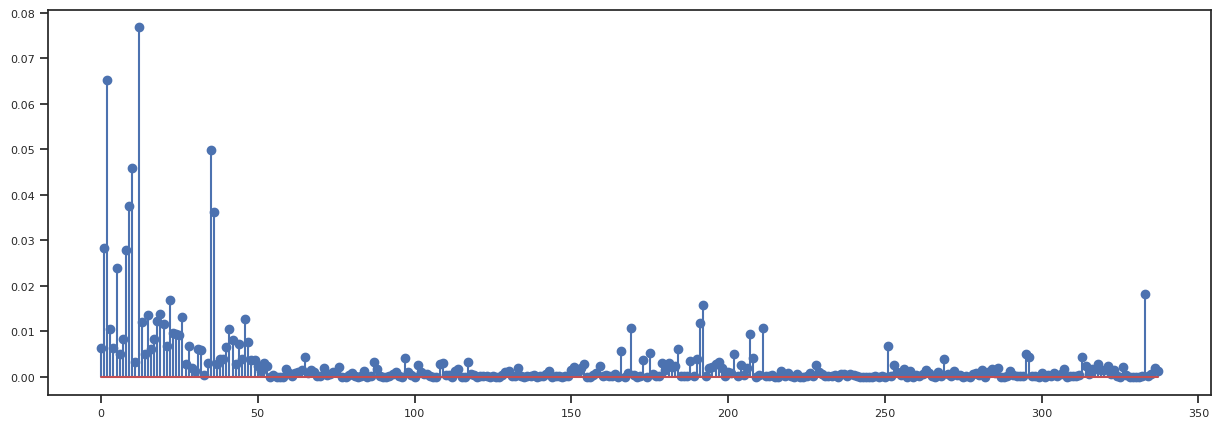

In [42]:
plt.figure(figsize=(15, 5))
plt.stem(imps)
plt.show()

In [43]:
def base_feature(f: str) -> str:
    if "_" in f:
        return f[:f.index("_")]
    else:
        return f

In [48]:
imp = pd.Series(
  index=pd.Index(features, name="Feature"),
  data=imps,
  name="Importance",
).sort_values(ascending=False).to_frame().reset_index()[:25]

px.scatter(imp, x="Feature", y="Importance", log_y=True, height=450, width=1250, title="Single")

In [49]:
imp0 = pd.Series(
  index=pd.Index(features, name="Feature"),
  data=imps,
  name="Importance",
)

imp1 = pd.Series(
  index=pd.Index(raw_features, name="Feature"),
  data=0.0,
  name="Importance",
)

for f in features:
  imp1[base_feature(f)] = imp1[base_feature(f)] + imp0[f]

imp1 = imp1.sort_values(ascending=False).to_frame().reset_index()[:25]

px.scatter(imp1, x="Feature", y="Importance", log_y=True, height=450, width=1250, title="Agregated")